# Lab 05 - Kernel Regularized Least Squares

In this lab activity we consider the extension of Regularized Least Squares to non-linear problems using kernel functions.

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import scipy.linalg
import os

### TASK 1 - Define a function to generate D-dimensional synthetic data non non-linear regression problems

In [2]:
def nonLinearRegrFunction(n, D, low_D, high_D, W, sigma_noise,omega,t,sigma):
   
    X = np.zeros((n,D))
    for i in range(0, D):
        X[:,i] = np.random.uniform(low_D[i], high_D[i], size=n)
    
    gauss_noise = np.random.normal(0, sigma_noise, size=(n,1))

    Y = np.dot(X*np.exp(-sigma * t) * np.sin(omega * t), W) + gauss_noise
     
    return X, Y

In [3]:
n = 200
D = 2
w = np.array([1,1]).transpose()
w.shape = (D,1)

omega = 0.1 * 2 * np.pi
t = 20
sigma = 0.1

low_D = np.array([-1, -1])
high_D = np.array([1, 1])

# Here we can compute the true function
Xtrue, Ytrue = nonLinearRegrFunction(n, D, low_D, high_D, w, 0.8,omega,t,sigma)

In [4]:
Xtrue1, Ytrue1 = nonLinearRegrFunction(n, D, low_D, high_D, w, 0.8,omega,t,sigma)

In [5]:
Ytrue1.shape

(200, 1)

The function <b>sqDist</b> computes all the distances between two sets of points stored in two matrices X1 and X2. Use it as follows:

##### D = sqDist(X1, X2)
where
- X1: a matrix of size [n1xd], where each row is a d-dimensional point
- X2: a matrix of size [n2xd], where each row is a d-dimensional point
- D: a [n1xn2] matrix where each element (D)_ij is the distance between points (X_i, X_j)


In [6]:
def sqDist(X1, X2):
    sqx = np.multiply(X1, X1) +1
    sqy = np.multiply(X2, X2)+1
    return np.outer(sqx, np.ones(sqy.shape[0])) + np.outer(np.ones(sqx.shape[0]), sqy.T) - 2 * np.dot(X1, X2.T)

The function <b>kernelMatrix</b> builds the matrix of the kernel (also called Gram matrix) between two sets of points stored in two matrices X1 and X2. Use is as follows:

##### K = kernelMatrix(X1, X2, kernel_type, param)
where
- X1, X2: collections of points on which to compute the Gram matrix
- kernel: can be 'linear', 'polynomial' or 'gaussian'
- param: is [] for the linear kernel, the exponent of the polynomial kernel, or the standard deviation for the gaussian kernel
- K: Gram matrix

### TASK 2 - Complete the computation of the kernel matrix depending on the specific kernel choice

In [7]:
def kernelMatrix(X1, X2, kernel_type, param):
   
    if kernel_type == 'linear':
        return  np.dot(X1.T,X2)
    elif kernel_type == 'polynomial':
        return  np.power((np.dot(X1.T,X2)+1),param) 
    elif kernel_type == 'gaussian':
        return np.exp((np.power(-np.linalg.norm(X1-X2),2))/2*param**2)

The function <b>regularizedKernLSTrain</b> computes the parameters of the function estimated on the training set. Use it as follows:

##### c = regularizedKernLSTrain(Xtr, Ytr, kernel, sigma, lam)
where
- Xtr: training input
- Ytr: training output
- kernel_type: type of kernel ('linear', 'polynomial', 'gaussian')
- param: is [] for the linear kernel, the exponent of the polynomial kernel, or the standard deviation for the gaussian kernel
- reg_par: regularization parameter
- c: model coefficients

### TASK 3 - Complete the computation of the c coefficients for the case when square loss is used

In [18]:
def regularizedKernLSTrain(Xtr, Ytr, kernel_type, param, reg_par):
   
    n = Xtr.shape[0]
    K = kernelMatrix(Xtr, Xtr, kernel_type, param)
    Z = reg_par * np.eye(Xtr.shape[0])
    #inv = np.linalg.inv(K+Z)
    c =  np.dot(np.linalg.inv(K+Z),Ytr) #c = (K+λI)**-1(y) 

    return c

In [19]:
c=regularizedKernLSTrain(Xtrue[:,0], Ytrue, 'linear', 0.9, 8)

The function <b>regularizedKernLSTest</b> applies an estimated function (previously called also model) to a test set, to verify its goodness. Use it as follows:

##### Ypred = regularizedKernLSTest(c, Xtr, kernel_type, param, Xte)
where
- c: model coefficients
- Xtr: training input
- kernel type: type of kernel ('linear', 'polynomial', 'gaussian')
- param: is [] for the linear kernel, the exponent of the polynomial kernel, or the standard deviation for the gaussian kernel
- Xte: test points
- Ypred: predicted output on the test set

In [10]:
def regularizedKernLSTest(c, Xtr, kernel_type, param, Xte):
   
    Ktest = kernelMatrix(Xte, Xtr, kernel_type, param)
    Ypred = np.dot(Ktest, c)

    return Ypred

In [11]:
Ypred = regularizedKernLSTest(c, Xtrue[:,0], 'linear', 0.6,Xtrue[:,0] )

The function <b>calcErr</b> computes the error between real and predicted output (for regression problems). Use it as follows:

##### err = calcErr(Ypred, Ytrue)

where
- Ypred: estimated (predicted) output
- Ytrue: true (correct) output
- err: error estimated as Mean Squared Error (MSE)

In [12]:
def calcErr(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

In [13]:
calcErr(Ypred, Ytrue)

33.72477605195408

Let's modify the function for <b>V-Fold Cross Validation</b>, you already used in the previous labs, to adapt it to the use with Kernel Regularized Least Squares 

In [14]:
def VFoldCVKernRLS(x, y, KF, kernel_type, lam_list, kerpar_list):
   
    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    if isinstance(kerpar_list, int):
        kerpar_list = np.array([kerpar_list])
    else:
        kerpar_list = np.array(kerpar_list)
    nkerpar = kerpar_list.size

    if isinstance(lam_list, int):
        lam_list = np.array([lam_list])
    else:
        lam_list = np.array(lam_list)
    nlambda = lam_list.size

    n = Xtr.shape[0]
    n_val = int(np.ceil(n/KF))
    ntr = n - n_val

    tm = np.zeros((nlambda, nkerpar))
    ts = np.zeros((nlambda, nkerpar))
    vm = np.zeros((nlambda, nkerpar))
    vs = np.zeros((nlambda, nkerpar))

    ym = float(y.max() + y.min()) / float(2)
    
     # Random permutation of training data
    rand_idx = np.random.choice(n, size=n, replace=False)

    il = 0
    for l in lam_list:
        iss = 0
        for s in kerpar_list:
            trerr = np.zeros((KF, 1))
            vlerr = np.zeros((KF, 1))
            first=0
            for fold in range(KF):
                
                flags = np.zeros(Xtr.shape[0])
                flags[first:first+n_val]=1;
            
                X = Xtr[rand_idx[flags==0]]
                Y = Ytr[rand_idx[flags==0]]
                X_val = Xtr[rand_idx[flags==1]]
                Y_val = Ytr[rand_idx[flags==1]]

                c = regularizedKernLSTrain(X, Y, kernel_type, s, l)
                
                trerr[fold] = calcErr(regularizedKernLSTest(c, X, kernel_type, s, X), Y)
                vlerr[fold] = calcErr(regularizedKernLSTest(c, X, kernel_type, s, X_val), Y_val)
                
            tm[il, iss] = np.median(trerr)
            ts[il, iss] = np.std(trerr)
            vm[il, iss] = np.median(vlerr)
            vs[il, iss] = np.std(vlerr)
            iss = iss + 1
        il = il + 1
    row, col = np.where(vm == np.amin(vm))
    l = lam_list[row]
    s = kerpar_list[col]

    return [l, s, vm, vs, tm, ts]

##### Now, let's move to the analysis...

### TASK 4 - Build a training and a test set using the function to generate synthetica data for non-linear regression problems you defined with TASK 1

Generate, for instance, 2-dimensional data in the range [-1, 1] with sigma_noise = 0.8

In [15]:
Xtr, Ytr =   nonLinearRegrFunction(n, D, low_D, high_D, w, 0.8,omega,t,sigma)
Xte, Yte =   nonLinearRegrFunction(n, D, low_D, high_D, w, 0.8,omega,t,sigma)

In [16]:
Xtr[:,0].shape
Ytrue.shape

(200, 1)

In [27]:
kerpar_list = [0.5] # for the time being let's use only one possible value for the kernel parameter
lam_list = [10, 7, 5, 2, 1, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00001, 0.000001]
V_Fold = 5

#, s, vm, vs, tm, ts = VFoldCVKernRLS(Xtrue[:,1] ,Ytrue, 5, "linear" , lam_list, kerpar_list)

### TASK 5 - Complete, where required, the final parts, considering first a gaussian and then a polynomial kernel

NameError: name 'tm' is not defined

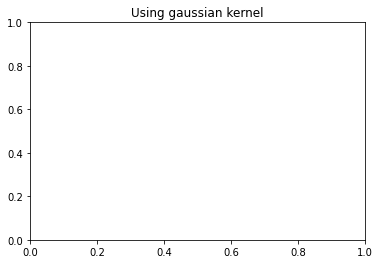

In [28]:
kerpar_list = [0.5] # for the time being let's use only one possible value for the kernel parameter
lam_list = [10, 7, 5, 2, 1, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00001, 0.000001]
V_Fold = 5

#l, s, vm, vs, tm, ts = VFoldCVKernRLS(Xtr[:,1], Ytr, 5, kernel_type, lam_list, kerpar_list)

fig, axs = plt.subplots(1,  1)
plt. title('Using gaussian kernel')
plt.semilogx(lam_list, tm, 'r')
plt.semilogx(lam_list, vm, 'b')
plt.legend(['Training error', 'Validation error'])
plt.grid()
plt.tight_layout()

params = [1,3,4]

# Now let's train the model with the best value for the parameters 
c = regularizedKernLSTrain(Xtr, Ytr, 'gaussian', param=s[0], reg_par=l[0])

# Predict the output on the test set with the estimated model
Ypred =  regularizedKernLSTest(c, Xtr, kernel_type, param, Xte)

# Compute the error between predicted and real output
err =  calcErr(Ypred, Ytr)

print('Test error: '+str(err)) 


In [23]:
c = regularizedKernLSTrain(Xtr[:,1], Ytr, 'gaussian', param=0.9 , reg_par=0.1)

In [ ]:
kerpar_list = [4] # for the time being let's use only one possible value for the kernel parameter
lam_list = [5, 2, 1, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001,0.00001,0.000001]
V_Fold = 5

l, s, vm, vs, tm, ts = VFoldCVKernRLS( # fill here

fig, axs = plt.subplots(1,  1)
plt. title('Using polynomial kernel')
plt.semilogx(lam_list, tm, 'r')
plt.semilogx(lam_list, vm, 'b')
plt.legend(['Training error', 'Validation error'])
plt.grid()
plt.tight_layout()

# Now let's train the model with the best value for the parameters 
c = regularizedKernLSTrain(Xtr, Ytr, 'polynomial', param=s[0], reg_par=l[0])

# Predict the output on the test set with the estimated model
Ypred = # fill here

# Compute the error between predicted and real output
err = # fill here

print('Test error: '+str(err))